AUC-ROC: 0.8575603048186557

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       563
           1       0.37      0.74      0.50        93

    accuracy                           0.79       656
   macro avg       0.66      0.77      0.68       656
weighted avg       0.87      0.79      0.81       656


Confusion Matrix:
[[447 116]
 [ 24  69]]


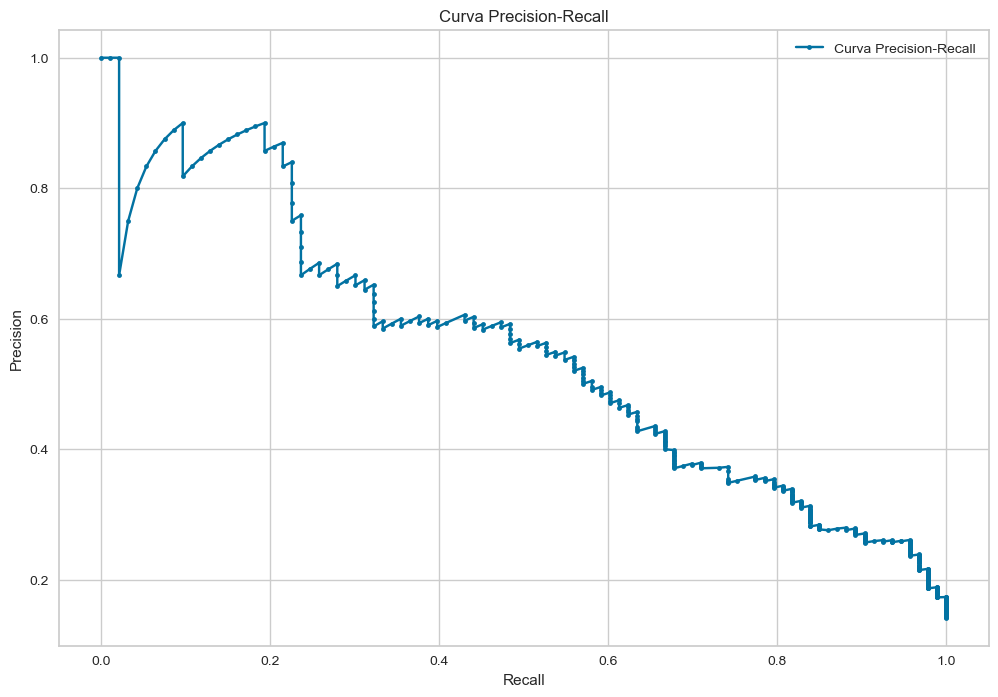

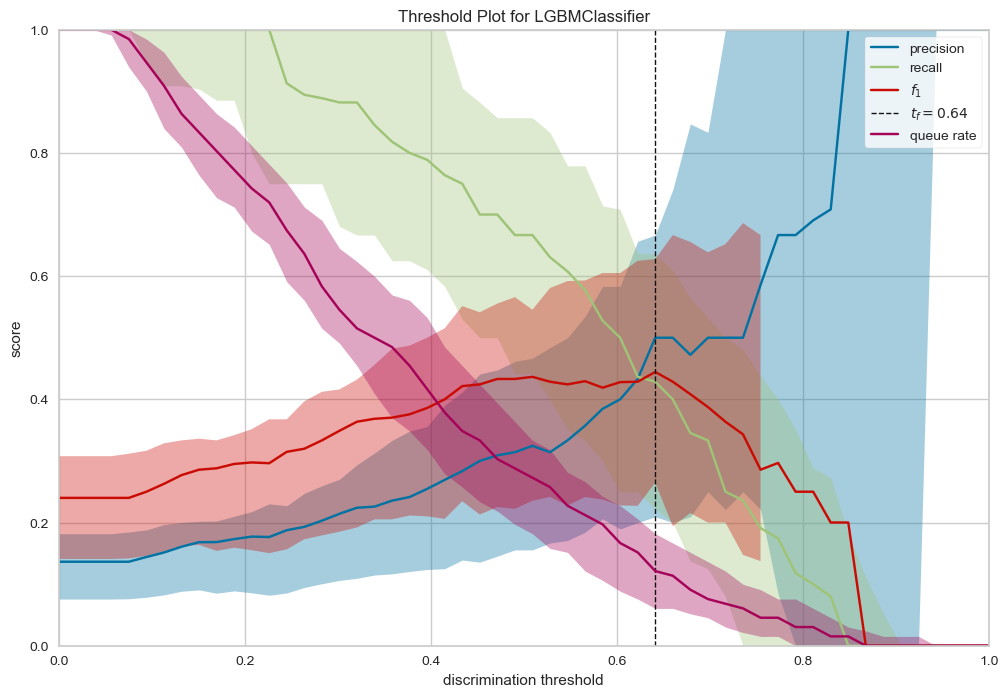

In [30]:
import cloudpickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from janitor import clean_names
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix
from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Ruta y archivo
ruta_proyecto = 'C:/Users/Alfonso/OneDrive/Documentos_/Formación/Bootcamp_DS/Repo_DS/Proyect_Break_ML/00_PROYECTO_ML'
nombre_fichero_datos = 'validacion.csv'
ruta_completa = f'{ruta_proyecto}/02_Datos/02_Validacion/{nombre_fichero_datos}'

# Cargar datos
df = pd.read_csv(ruta_completa, index_col=0)
df = clean_names(df).drop_duplicates()

# Preprocesamiento
dicc_status = {
    'Together': 2,
    'Divorced': 1,
    'Married': 2,
    'Single': 1,
    'Widow': 1,
    'OTROS': 1
}
df['status_members'] = df['marital_status'].map(dicc_status)
df['household_members'] = df['status_members'] + df['kidhome'] + df['teenhome']
df['total_cmp'] = df.filter(like='accepted').apply(pd.to_numeric, errors='coerce').sum(axis=1)
train_set_numeric = df.filter(like='cmp').apply(pd.to_numeric, errors='coerce')
df = df.drop(columns=['status_members'])

# Variables finales
variables_finales = ['household_members', 'income', 'mntgoldprods', 'mntmeatproducts',
                    'mntwines', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',  'total_cmp']
X = df[variables_finales]

# Cargar modelo
nombre_pipe_ejecucion = 'pipe_ejecucion.pickle'
ruta_pipe_ejecucion = f'{ruta_proyecto}/04_Modelos/{nombre_pipe_ejecucion}'

with open(ruta_pipe_ejecucion, mode='rb') as file:
    pipe_ejecucion = cloudpickle.load(file)

# Función para hacer la predicción
def hacer_prediccion(datos, umbral):
    probabilidades = pipe_ejecucion.predict_proba(datos)[:, 1]
    return (probabilidades >= umbral).astype(int), probabilidades

# Función para ajustar el umbral
def ajustar_umbral(modelo, X, y, objetivo='recall', clase='positiva'):
    probabilidades = modelo.predict_proba(X)[:, 1]
    precision, recall, umbrales = precision_recall_curve(y, probabilidades)
    
    if objetivo == 'recall' and clase == 'positiva':
        mejor_umbral = umbrales[recall.argmax()]
        mejor_metrica = recall.max()
    elif objetivo == 'precision' and clase == 'positiva':
        mejor_umbral = umbrales[precision.argmax()]
        mejor_metrica = precision.max()
    else:
        raise ValueError("El objetivo debe ser 'recall' o 'precision' y la clase debe ser 'positiva'")
    
    return mejor_umbral, mejor_metrica, precision, recall, umbrales

# Evaluar el modelo
y_true = df['response']  # Suponiendo que 'response' es la columna de etiquetas verdaderas
scoring = pipe_ejecucion.predict_proba(X)[:, 1]

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_true, scoring)

# Classification report y matriz de confusión
y_pred = pipe_ejecucion.predict(X)
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Ajustar umbrales
umbral_captacion, _, precision, recall, umbrales = ajustar_umbral(pipe_ejecucion, X, y_true, objetivo='recall', clase='positiva')
umbral_coste, _, _, _, _ = ajustar_umbral(pipe_ejecucion, X, y_true, objetivo='precision', clase='positiva')

# Imprimir resultados
print(f'AUC-ROC: {auc_roc}')
print()
print(f'Classification Report:\n{report}')
print()
print(f'Confusion Matrix:\n{conf_matrix}')

# Gráfica de precision-recall
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(recall, precision, marker='.', label='Curva Precision-Recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curva Precision-Recall')
ax.legend()
plt.show()

# Gráfica de umbral de corte con Yellowbrick
fig, ax = plt.subplots(figsize=(12, 8))
viz = DiscriminationThreshold(pipe_ejecucion, ax=ax)
viz.fit(X, y_true)
viz.show()
plt.show()


In [36]:
def calcular_metricas(real, scoring, umbral):
    # CALCULAR LA DECISIÓN SEGÚN EL UMBRAL
    predicho = np.where(scoring > umbral, 1, 0)
    
    # CALCULAR TODAS LAS MÉTRICAS
    conf = confusion_matrix(real, predicho)
    tn, fp, fn, tp = conf.ravel()
    total_casos = real.shape[0]
    
    accuracy = (tn + tp) / total_casos
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # IMPRIMIR RESULTADOS
    print('\nMatriz de confusión\n', pd.DataFrame(conf))
    print('\naccuracy:', round(accuracy, 3))
    print('\nprecision:', round(precision, 3))
    print('\nrecall:', round(recall, 3))
    print('\nF1:', round(F1, 3))

    return precision, recall


# Variables para almacenar los mejores resultados
mejor_precision = 0
mejor_recall = 0
mejor_umbral = 0

# Evaluar los umbrales
for umbral in range(25, 40, 1):
    print(f'Para umbral {umbral / 100}')
    precision, recall = calcular_metricas(y_true, scoring, umbral=umbral / 100)
    
    # Verificar si este umbral es el mejor según los criterios
    if precision > mejor_precision and recall >= mejor_recall:
        mejor_precision = precision
        mejor_recall = recall
        mejor_umbral = umbral / 100
    
    print('#' * 25)
    print()

print(f'Mejor umbral: {mejor_umbral}')
print(f'Mejor precisión: {mejor_precision}')
print(f'Mejor recall: {mejor_recall}')

Para umbral 0.25

Matriz de confusión
      0    1
0  227  336
1    2   91

accuracy: 0.485

precision: 0.213

recall: 0.978

F1: 0.35
#########################

Para umbral 0.26

Matriz de confusión
      0    1
0  240  323
1    3   90

accuracy: 0.503

precision: 0.218

recall: 0.968

F1: 0.356
#########################

Para umbral 0.27

Matriz de confusión
      0    1
0  254  309
1    3   90

accuracy: 0.524

precision: 0.226

recall: 0.968

F1: 0.366
#########################

Para umbral 0.28

Matriz de confusión
      0    1
0  269  294
1    3   90

accuracy: 0.547

precision: 0.234

recall: 0.968

F1: 0.377
#########################

Para umbral 0.29

Matriz de confusión
      0    1
0  274  289
1    3   90

accuracy: 0.555

precision: 0.237

recall: 0.968

F1: 0.381
#########################

Para umbral 0.3

Matriz de confusión
      0    1
0  280  283
1    4   89

accuracy: 0.562

precision: 0.239

recall: 0.957

F1: 0.383
#########################

Para umbral 0.31

Matriz

VALORES UMBRALES RECALL
Para un modelo agresivo en la captación de clientes:
- Mejor umbral: 0.34    
- Mejor precisión: 0.257   
- Mejor recall: 0.957

Para un modelo moderado en la captación de clientes:
- Mejor umbral: 0.43    
- Mejor precisión: 0.313    
- Mejor recall: 0.839

Para equilibrio entre captación y costes:
- Mejor umbral: 0.67   
- Mejor precisión: 0.551   
- Mejor recall: 0.527

VALORES UMBRALES PRECISION
Para Maximizar los costes:
- Mejor umbral: 0.82    
- Mejor precisión: 0.808    
- Mejor recall: 0.226